
EmotiBot - Session 1: Text Emotion Detection
Fine-tuning DistilBERT on GoEmotions Dataset

This notebook implements Phase 1 of the EmotiBot project:
- Load and preprocess GoEmotions dataset
- Fine-tune DistilBERT for 27-class emotion classification
- Evaluate and save the model to Google Drive

Environment: Google Colab (Free Tier)


```
# This is formatted as code
```



In [1]:

!pip install -q transformers datasets accelerate evaluate scikit-learn



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/84.1 kB ? eta -:--:--
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 6.1 MB/s eta 0:00:00


In [2]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.metrics import classification_report, confusion_matrix
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    AutoConfig,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback
)
from google.colab import drive
import os
import json
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Mount Google Drive
print("Mounting Google Drive...")
drive.mount('/content/drive')



Mounting Google Drive...
Mounted at /content/drive


In [4]:
# Create project directory structure
PROJECT_DIR = '/content/drive/MyDrive/EmotiBot'
MODELS_DIR = os.path.join(PROJECT_DIR, 'models')
PLOTS_DIR = os.path.join(PROJECT_DIR, 'plots')
LOGS_DIR = os.path.join(PROJECT_DIR, 'logs')
DATA_DIR = os.path.join(PROJECT_DIR, 'processed_data')

for directory in [PROJECT_DIR, MODELS_DIR, PLOTS_DIR, LOGS_DIR, DATA_DIR]:
    os.makedirs(directory, exist_ok=True)

print(f"✓ Project directory created at: {PROJECT_DIR}")

✓ Project directory created at: /content/drive/MyDrive/EmotiBot


In [5]:
# Check GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"✓ Using device: {device}")
if torch.cuda.is_available():
    print(f"  GPU: {torch.cuda.get_device_name(0)}")
    print(f"  Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

✓ Using device: cuda
  GPU: Tesla T4
  Memory: 15.83 GB


In [6]:

# ============================================================================
# TEXT PREPROCESSING AND CLEANING
# ============================================================================

print("\n" + "="*80)
print("TEXT PREPROCESSING SETUP")
print("="*80)

class TextPreprocessor:
    """BERT-appropriate minimal text preprocessing for emotion detection

    BERT models work best with raw, natural text because:
    - They use WordPiece tokenization (handles subwords)
    - Pre-trained on natural language (including stopwords)
    - Case information is encoded in embeddings
    - Punctuation carries semantic meaning

    We only remove noise, NOT linguistic features.
    """

    def __init__(self):
        # No stopword removal for BERT!
        pass

    def clean_text(self, text):
        """Minimal cleaning - preserve natural language structure"""
        if not isinstance(text, str):
            return ""

        original_text = text

        # 1. Remove URLs (noise, not linguistic content)
        text = re.sub(r'http\S+|www\.\S+', '', text)

        # 2. Remove email addresses (PII and noise)
        text = re.sub(r'\S+@\S+', '', text)

        # 3. Remove user mentions and hashtags formatting (keep the word)
        text = re.sub(r'@\w+', '', text)  # Remove @mentions
        text = re.sub(r'#(\w+)', r'\1', text)  # Keep hashtag content

        # 4. MINIMAL punctuation normalization
        # Only extreme cases - BERT needs punctuation for context!
        text = re.sub(r'([!?.]){4,}', r'\1\1\1', text)  # Max 3 repetitions

        # 5. MINIMAL character normalization
        # Only extreme repetitions (4+ chars) - preserve emphasis like "sooo"
        text = re.sub(r'(.)\1{3,}', r'\1\1', text)  # "soooo" -> "soo"

        # 6. Normalize whitespace only
        text = re.sub(r'\s+', ' ', text).strip()

        # 7. Preserve case, punctuation, contractions!
        # DON'T: lowercase, expand contractions, remove stopwords
        # "I'm not happy!" stays as "I'm not happy!"

        return text

    def validate_text(self, text):
        """Validate if text is meaningful"""
        if not text or len(text.strip()) < 3:
            return False
        if len(text.split()) < 2:  # At least 2 words
            return False
        return True

# Initialize preprocessor (BERT-appropriate: minimal preprocessing)
preprocessor = TextPreprocessor()
print("✓ Text preprocessor initialized (BERT-optimized: minimal preprocessing)")
print("  → Preserving: case, punctuation, contractions, stopwords")
print("  → Removing: only URLs, emails, extreme repetitions")


TEXT PREPROCESSING SETUP
✓ Text preprocessor initialized (BERT-optimized: minimal preprocessing)
  → Preserving: case, punctuation, contractions, stopwords
  → Removing: only URLs, emails, extreme repetitions


In [7]:
# ============================================================================
# LOAD AND EXPLORE GOEMOTIONS DATASET
# ============================================================================

print("\n" + "="*80)
print("LOADING GOEMOTIONS DATASET")
print("="*80)

try:
    dataset = load_dataset("go_emotions", "simplified")
    print(f"✓ Dataset loaded successfully!")
except Exception as e:
    print(f"❌ Error loading dataset: {e}")
    raise

print(f"  Train samples: {len(dataset['train'])}")
print(f"  Validation samples: {len(dataset['validation'])}")
print(f"  Test samples: {len(dataset['test'])}")

# Get emotion labels
emotion_labels = dataset['train'].features['labels'].feature.names
num_labels = len(emotion_labels)
print(f"\n✓ Number of emotion classes: {num_labels}")
print(f"  Emotions: {emotion_labels}")

# Create label mapping
id2label = {i: label for i, label in enumerate(emotion_labels)}
label2id = {label: i for i, label in enumerate(emotion_labels)}

# Save label mapping
with open(os.path.join(MODELS_DIR, 'emotion_labels.json'), 'w') as f:
    json.dump({'id2label': id2label, 'label2id': label2id}, f, indent=2)


LOADING GOEMOTIONS DATASET


README.md: 0.00B [00:00, ?B/s]

simplified/train-00000-of-00001.parquet:   0%|          | 0.00/2.77M [00:00<?, ?B/s]

simplified/validation-00000-of-00001.par(…):   0%|          | 0.00/350k [00:00<?, ?B/s]

simplified/test-00000-of-00001.parquet:   0%|          | 0.00/347k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/43410 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5426 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5427 [00:00<?, ? examples/s]

✓ Dataset loaded successfully!
  Train samples: 43410
  Validation samples: 5426
  Test samples: 5427

✓ Number of emotion classes: 28
  Emotions: ['admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise', 'neutral']


In [8]:



print("\n" + "="*80)
print("DATA CLEANING AND VALIDATION")
print("="*80)

def clean_dataset(dataset_split, split_name):
    """Clean text and remove invalid samples, returning updated dataset"""

    original_count = len(dataset_split)

    def process_example(example):
        """Clean text for each example"""
        cleaned_text = preprocessor.clean_text(example['text'])
        example['text'] = cleaned_text  # Update with cleaned text
        example['is_valid'] = preprocessor.validate_text(cleaned_text) and len(example['labels']) > 0
        return example

    # Apply cleaning to all examples
    processed_dataset = dataset_split.map(
        process_example,
        desc=f"Cleaning {split_name} text"
    )

    # Filter out invalid samples
    cleaned_dataset = processed_dataset.filter(
        lambda example: example['is_valid'],
        desc=f"Filtering {split_name}"
    )

    # Remove the temporary 'is_valid' column
    cleaned_dataset = cleaned_dataset.remove_columns(['is_valid'])

    removed_count = original_count - len(cleaned_dataset)
    print(f"✓ {split_name} set:")
    print(f"  Original: {original_count} samples")
    print(f"  Cleaned: {len(cleaned_dataset)} samples")
    print(f"  Removed: {removed_count} samples ({removed_count/original_count*100:.2f}%)")

    # Show example of cleaning
    if len(cleaned_dataset) > 0:
        original_sample = dataset_split[0]['text']
        cleaned_sample = cleaned_dataset[0]['text']
        if original_sample != cleaned_sample:
            print(f"  Example change:")
            print(f"    Before: '{original_sample[:70]}...'")
            print(f"    After:  '{cleaned_sample[:70]}...'")

    return cleaned_dataset

# Clean all splits - text is now updated with cleaned version
dataset['train'] = clean_dataset(dataset['train'], 'Train')
dataset['validation'] = clean_dataset(dataset['validation'], 'Validation')
dataset['test'] = clean_dataset(dataset['test'], 'Test')

print(f"\n✓ All datasets cleaned and updated!")


DATA CLEANING AND VALIDATION


Cleaning Train text:   0%|          | 0/43410 [00:00<?, ? examples/s]

Filtering Train:   0%|          | 0/43410 [00:00<?, ? examples/s]

✓ Train set:
  Original: 43410 samples
  Cleaned: 43276 samples
  Removed: 134 samples (0.31%)


Cleaning Validation text:   0%|          | 0/5426 [00:00<?, ? examples/s]

Filtering Validation:   0%|          | 0/5426 [00:00<?, ? examples/s]

✓ Validation set:
  Original: 5426 samples
  Cleaned: 5408 samples
  Removed: 18 samples (0.33%)


Cleaning Test text:   0%|          | 0/5427 [00:00<?, ? examples/s]

Filtering Test:   0%|          | 0/5427 [00:00<?, ? examples/s]

✓ Test set:
  Original: 5427 samples
  Cleaned: 5410 samples
  Removed: 17 samples (0.31%)

✓ All datasets cleaned and updated!


In [9]:

# ============================================================================
# FOCAL LOSS FOR SEVERE CLASS IMBALANCE
# ============================================================================

class FocalLoss(nn.Module):
    """
    Focal Loss for multi-label classification
    Better than BCE for imbalanced data

    FL(p_t) = -alpha * (1 - p_t)^gamma * log(p_t)

    gamma: focusing parameter (higher = focus more on hard examples)
    alpha: class balancing weight
    """

    def __init__(self, alpha=None, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha  # Class weights
        self.gamma = gamma  # Focusing parameter
        self.reduction = reduction

    def forward(self, logits, targets):
        """
        Args:
            logits: (batch_size, num_classes) - raw scores
            targets: (batch_size, num_classes) - binary labels
        """
        # Convert to probabilities
        probs = torch.sigmoid(logits)

        # Calculate focal weight
        # For positive samples: (1 - p)^gamma
        # For negative samples: p^gamma
        pt = torch.where(targets == 1, probs, 1 - probs)
        focal_weight = (1 - pt) ** self.gamma

        # Binary cross entropy
        bce = F.binary_cross_entropy_with_logits(
            logits, targets, reduction='none'
        )

        # Apply focal weight
        focal_loss = focal_weight * bce

        # Apply class weights if provided
        if self.alpha is not None:
            alpha_weight = torch.where(
                targets == 1,
                self.alpha,
                1.0
            )
            focal_loss = alpha_weight * focal_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

print("✓ Focal Loss implemented")


✓ Focal Loss implemented


In [19]:
from transformers import AutoModelForSequenceClassification, AutoConfig
import torch.nn as nn
from transformers.modeling_outputs import SequenceClassifierOutput

class EmotionClassifierWithDropout(nn.Module):
    def __init__(self, model_name, num_labels, dropout_rate=0.4):
        super().__init__()

        # Load config with updated dropout settings
        config = AutoConfig.from_pretrained(
            model_name,
            num_labels=num_labels,
            problem_type="multi_label_classification",
            hidden_dropout_prob=dropout_rate,
            attention_probs_dropout_prob=dropout_rate
        )

        # Load classification model (this gives you logits automatically)
        self.model = AutoModelForSequenceClassification.from_pretrained(
            model_name,
            config=config
        )

        # Extra dropout for stronger regularization
        self.extra_dropout = nn.Dropout(dropout_rate)



    def forward(self, input_ids=None, attention_mask=None, labels=None):
        outputs = self.model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=None
        )

        logits = self.extra_dropout(outputs.logits)

        return SequenceClassifierOutput(
            logits=logits,
            loss=None
        )



CLASS IMBALANCE ANALYSIS


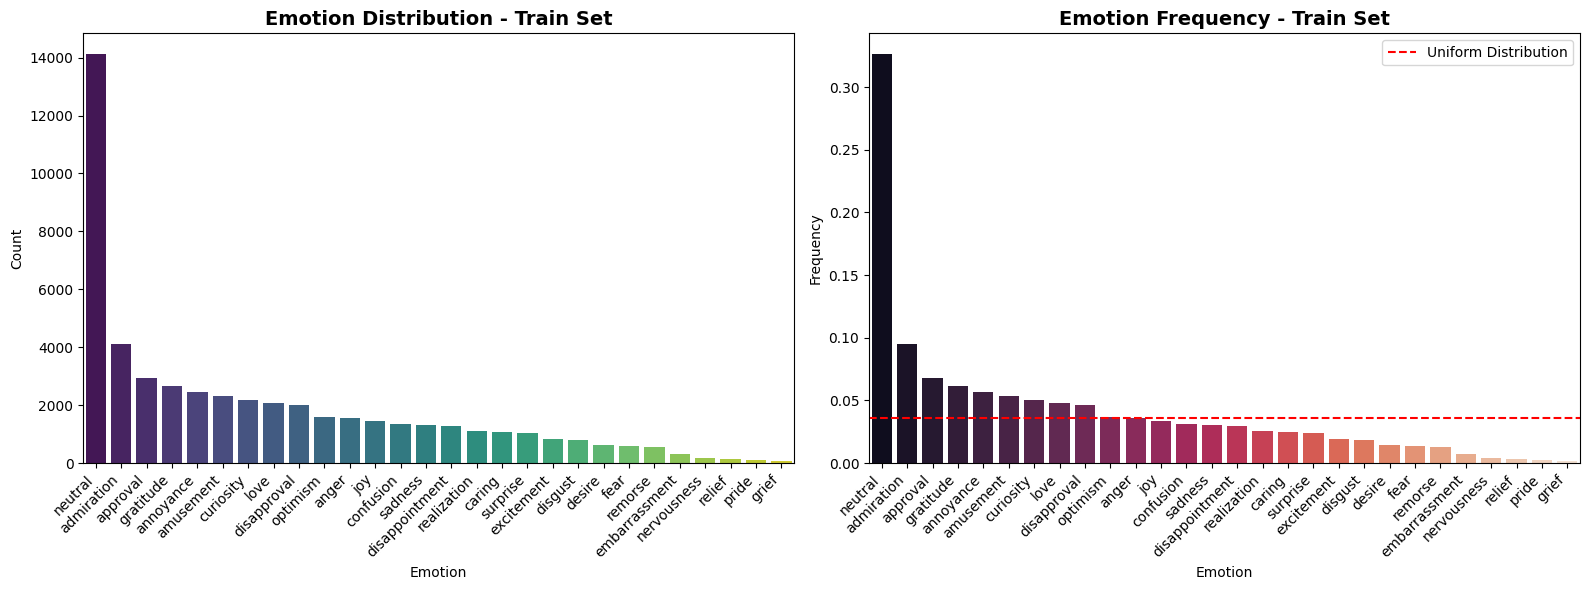


✓ Train Distribution:
  Most common: neutral (14132)
  Least common: grief (77)
  Imbalance ratio: 183.53:1

✓ Class weights (top 10 by weight):
       emotion  count  weight
         anger 1561.0     5.0
disappointment 1269.0     5.0
     confusion 1368.0     5.0
        caring 1087.0     5.0
       disgust  790.0     5.0
        desire  641.0     5.0
           joy 1448.0     5.0
   nervousness  164.0     5.0
         grief   77.0     5.0
          fear  596.0     5.0


In [11]:
# ============================================================================
# CLASS IMBALANCE ANALYSIS (SINGLE, CONSOLIDATED VERSION)
# ============================================================================

print("\n" + "="*80)
print("CLASS IMBALANCE ANALYSIS")
print("="*80)

# Count samples per emotion
emotion_counts = np.zeros(num_labels)
for example in dataset['train']:
    for label_idx in example['labels']:
        emotion_counts[label_idx] += 1

total_samples = len(dataset['train'])

# Calculate class frequencies
class_freq = emotion_counts / total_samples

# Create visualization
df = pd.DataFrame({
    'Emotion': emotion_labels,
    'Count': emotion_counts,
    'Frequency': class_freq
}).sort_values('Count', ascending=False)

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

sns.barplot(data=df, x='Emotion', y='Count', ax=ax1, palette='viridis')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
ax1.set_title('Emotion Distribution - Train Set', fontsize=14, fontweight='bold')
ax1.set_ylabel('Count')

sns.barplot(data=df, x='Emotion', y='Frequency', ax=ax2, palette='rocket')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')
ax2.set_title('Emotion Frequency - Train Set', fontsize=14, fontweight='bold')
ax2.set_ylabel('Frequency')
ax2.axhline(y=1/num_labels, color='r', linestyle='--', label='Uniform Distribution')
ax2.legend()

plt.tight_layout()
plt.savefig(os.path.join(PLOTS_DIR, 'distribution_train.png'), dpi=300, bbox_inches='tight')
plt.show()

# Calculate imbalance ratio
max_freq = class_freq.max()
min_freq = class_freq[class_freq > 0].min()  # Exclude zeros
imbalance_ratio = max_freq / min_freq

print(f"\n✓ Train Distribution:")
print(f"  Most common: {df.iloc[0]['Emotion']} ({df.iloc[0]['Count']:.0f})")
print(f"  Least common: {df.iloc[-1]['Emotion']} ({df.iloc[-1]['Count']:.0f})")
print(f"  Imbalance ratio: {imbalance_ratio:.2f}:1")

# Calculate weights (aggressive smoothing)
alpha_weights = []
for count in emotion_counts:
    if count > 0:
        weight = np.sqrt(total_samples / count)
        weight = np.clip(weight, 0.5, 5.0)
    else:
        weight = 1.0
    alpha_weights.append(weight)

alpha_tensor = torch.tensor(alpha_weights, dtype=torch.float32).to(device)

print("\n✓ Class weights (top 10 by weight):")
weight_df = pd.DataFrame({
    'emotion': emotion_labels,
    'count': emotion_counts,
    'weight': alpha_weights
}).sort_values('weight', ascending=False)

print(weight_df.head(10).to_string(index=False))

# Save weights
np.save(os.path.join(MODELS_DIR, 'class_weights.npy'), alpha_weights)


In [12]:

print("\n" + "="*80)
print("TOKENIZATION")
print("="*80)

MODEL_NAME = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def preprocess_function(examples):
    tokenized = tokenizer(
        examples['text'],
        truncation=True,
        padding='max_length',
        max_length=128,
        return_attention_mask=True
    )

    # Multi-label binary vectors
    labels = []
    for label_list in examples['labels']:
        label_vector = [0.0] * num_labels
        for label_idx in label_list:
            label_vector[label_idx] = 1.0
        labels.append(label_vector)

    tokenized['labels'] = labels
    return tokenized

tokenized_datasets = dataset.map(
    preprocess_function,
    batched=True,
    remove_columns=dataset['train'].column_names,
    desc="Tokenizing"
)

print("✓ Tokenization complete")


TOKENIZATION


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Tokenizing:   0%|          | 0/43276 [00:00<?, ? examples/s]

Tokenizing:   0%|          | 0/5408 [00:00<?, ? examples/s]

Tokenizing:   0%|          | 0/5410 [00:00<?, ? examples/s]

✓ Tokenization complete


In [20]:

# ============================================================================
# CUSTOM TRAINER WITH FOCAL LOSS
# ============================================================================

class FocalLossTrainer(Trainer):
    def __init__(self, *args, focal_loss_fn=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.focal_loss_fn = focal_loss_fn

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits

        # Use Focal Loss
        loss = self.focal_loss_fn(logits, labels.float())

        return (loss, outputs) if return_outputs else loss

print("✓ Custom Trainer with Focal Loss ready")

✓ Custom Trainer with Focal Loss ready


In [21]:

# ============================================================================
# INITIALIZE MODEL
# ============================================================================

print("\n" + "="*80)
print("MODEL INITIALIZATION")
print("="*80)

# Create model with higher dropout
model = EmotionClassifierWithDropout(
    MODEL_NAME,
    num_labels=num_labels,
    dropout_rate=0.4  # Increased from 0.1
)
model.to(device)

# Initialize Focal Loss
focal_loss = FocalLoss(
    alpha=alpha_tensor,
    gamma=2.0,  # Focus on hard examples
    reduction='mean'
)

print(f"✓ Model initialized with dropout=0.4")
print(f"✓ Focal Loss: gamma=2.0, weighted by class frequency")


MODEL INITIALIZATION


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✓ Model initialized with dropout=0.4
✓ Focal Loss: gamma=2.0, weighted by class frequency


In [22]:

print("\n" + "="*80)
print("TRAINING CONFIGURATION")
print("="*80)

training_args = TrainingArguments(
    output_dir=os.path.join(MODELS_DIR, 'distilbert_focal'),
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="macro_f1",
    greater_is_better=True,
    save_total_limit=2,

    learning_rate=2e-5,
    warmup_ratio=0.2,
    warmup_steps=0,

    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    gradient_accumulation_steps=2,

    num_train_epochs=5,

    weight_decay=0.05,
    max_grad_norm=0.5,
    label_smoothing_factor=0.0,

    logging_dir=LOGS_DIR,
    logging_steps=50,
    logging_first_step=True,
    report_to=["tensorboard"],

    fp16=False,
    dataloader_num_workers=2,
    remove_unused_columns=False,
    lr_scheduler_type="cosine",
)

print("✓ Training Configuration:")
print(f"  Learning rate: {training_args.learning_rate}")
print(f"  Weight decay: {training_args.weight_decay}")
print(f"  Dropout: 0.4")
print(f"  Label smoothing: {training_args.label_smoothing_factor}")
print(f"  Epochs: {training_args.num_train_epochs}")
print(f"  Effective batch size: {training_args.per_device_train_batch_size * training_args.gradient_accumulation_steps}")


TRAINING CONFIGURATION
✓ Training Configuration:
  Learning rate: 2e-05
  Weight decay: 0.05
  Dropout: 0.4
  Label smoothing: 0.0
  Epochs: 5
  Effective batch size: 32


In [23]:
def compute_metrics(eval_pred):
    """Compute metrics with optimal threshold per emotion"""
    predictions, labels = eval_pred
    probs = 1 / (1 + np.exp(-predictions))

    # Find optimal threshold per emotion
    best_thresholds = []
    for i in range(num_labels):
        thresholds = np.arange(0.3, 0.7, 0.05)
        best_f1 = 0
        best_thresh = 0.5

        for thresh in thresholds:
            preds_i = (probs[:, i] > thresh).astype(int)

            tp = ((preds_i == 1) & (labels[:, i] == 1)).sum()
            fp = ((preds_i == 1) & (labels[:, i] == 0)).sum()
            fn = ((preds_i == 0) & (labels[:, i] == 1)).sum()

            precision = tp / (tp + fp) if (tp + fp) > 0 else 0
            recall = tp / (tp + fn) if (tp + fn) > 0 else 0
            f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

            if f1 > best_f1:
                best_f1 = f1
                best_thresh = thresh

        best_thresholds.append(best_thresh)

    # Use optimal thresholds
    preds = np.zeros_like(probs)
    for i, thresh in enumerate(best_thresholds):
        preds[:, i] = (probs[:, i] > thresh).astype(int)

    # Calculate metrics
    exact_match = (preds == labels).all(axis=1).mean()

    precision_list, recall_list, f1_list = [], [], []

    for i in range(num_labels):
        tp = ((preds[:, i] == 1) & (labels[:, i] == 1)).sum()
        fp = ((preds[:, i] == 1) & (labels[:, i] == 0)).sum()
        fn = ((preds[:, i] == 0) & (labels[:, i] == 1)).sum()

        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

        precision_list.append(precision)
        recall_list.append(recall)
        f1_list.append(f1)

    # Micro metrics
    tp_total = ((preds == 1) & (labels == 1)).sum()
    fp_total = ((preds == 1) & (labels == 0)).sum()
    fn_total = ((preds == 0) & (labels == 1)).sum()

    micro_precision = tp_total / (tp_total + fp_total) if (tp_total + fp_total) > 0 else 0
    micro_recall = tp_total / (tp_total + fn_total) if (tp_total + fn_total) > 0 else 0
    micro_f1 = 2 * micro_precision * micro_recall / (micro_precision + micro_recall) if (micro_precision + micro_recall) > 0 else 0

    return {
        'exact_match': exact_match,
        'macro_precision': np.mean(precision_list),
        'macro_recall': np.mean(recall_list),
        'macro_f1': np.mean(f1_list),
        'micro_precision': micro_precision,
        'micro_recall': micro_recall,
        'micro_f1': micro_f1,
        'avg_threshold': np.mean(best_thresholds)
    }

In [24]:

# ============================================================================
# INITIALIZE TRAINER
# ============================================================================

trainer = FocalLossTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['validation'],
    compute_metrics=compute_metrics,
    focal_loss_fn=focal_loss,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

print("✓ Trainer initialized with Focal Loss")

✓ Trainer initialized with Focal Loss


In [25]:

print("\n" + "="*80)
print("STARTING TRAINING")
print("="*80)

start_time = datetime.now()
print(f"Started: {start_time.strftime('%Y-%m-%d %H:%M:%S')}")
print("\n⚠️  MONITORING:")
print("  - Watch for validation loss (should DECREASE)")
print("  - Target: Macro F1 > 0.55")
print("  - Expect: Balanced precision-recall\n")

train_result = trainer.train()

end_time = datetime.now()
duration = end_time - start_time

print(f"\n✓ Training completed!")
print(f"  Duration: {duration}")
print(f"  Final train loss: {train_result.training_loss:.4f}")


STARTING TRAINING
Started: 2025-11-16 11:30:27

⚠️  MONITORING:
  - Watch for validation loss (should DECREASE)
  - Target: Macro F1 > 0.55
  - Expect: Balanced precision-recall



Epoch,Training Loss,Validation Loss,Exact Match,Macro Precision,Macro Recall,Macro F1,Micro Precision,Micro Recall,Micro F1,Avg Threshold
1,0.118000,0.075247,0.344859,0.471418,0.520992,0.480533,0.496999,0.637850,0.558684,0.508929
2,0.111300,0.064054,0.384615,0.507155,0.569684,0.517942,0.529596,0.638478,0.578962,0.501786
3,0.107600,0.059744,0.411428,0.547103,0.578336,0.543978,0.556080,0.647595,0.598359,0.521429
4,0.105400,0.057719,0.382212,0.561288,0.562851,0.540135,0.534336,0.681232,0.598908,0.532143


Epoch,Training Loss,Validation Loss,Exact Match,Macro Precision,Macro Recall,Macro F1,Micro Precision,Micro Recall,Micro F1,Avg Threshold
1,0.118000,0.075247,0.344859,0.471418,0.520992,0.480533,0.496999,0.637850,0.558684,0.508929
2,0.111300,0.064054,0.384615,0.507155,0.569684,0.517942,0.529596,0.638478,0.578962,0.501786
3,0.107600,0.059744,0.411428,0.547103,0.578336,0.543978,0.556080,0.647595,0.598359,0.521429
4,0.105400,0.057719,0.382212,0.561288,0.562851,0.540135,0.534336,0.681232,0.598908,0.532143
5,0.103700,0.056858,0.377034,0.529323,0.577272,0.534834,0.523101,0.690506,0.595257,0.523214



✓ Training completed!
  Duration: 0:36:25.953597
  Final train loss: 0.1123


In [26]:

print("\n" + "="*80)
print("EVALUATION")
print("="*80)

val_metrics = trainer.evaluate(tokenized_datasets['validation'])
test_metrics = trainer.evaluate(tokenized_datasets['test'])

print("\n✓ Validation Metrics:")
for key, value in val_metrics.items():
    if isinstance(value, (int, float)):
        print(f"  {key}: {value:.4f}")

print("\n✓ Test Metrics:")
for key, value in test_metrics.items():
    if isinstance(value, (int, float)):
        print(f"  {key}: {value:.4f}")




EVALUATION



✓ Validation Metrics:
  eval_loss: 0.0597
  eval_exact_match: 0.4114
  eval_macro_precision: 0.5471
  eval_macro_recall: 0.5783
  eval_macro_f1: 0.5440
  eval_micro_precision: 0.5561
  eval_micro_recall: 0.6476
  eval_micro_f1: 0.5984
  eval_avg_threshold: 0.5214
  eval_runtime: 17.1340
  eval_samples_per_second: 315.6300
  eval_steps_per_second: 9.8630
  epoch: 5.0000

✓ Test Metrics:
  eval_loss: 0.0599
  eval_exact_match: 0.4006
  eval_macro_precision: 0.5593
  eval_macro_recall: 0.5443
  eval_macro_f1: 0.5294
  eval_micro_precision: 0.5451
  eval_micro_recall: 0.6749
  eval_micro_f1: 0.6031
  eval_avg_threshold: 0.5286
  eval_runtime: 17.2474
  eval_samples_per_second: 313.6700
  eval_steps_per_second: 9.8570
  epoch: 5.0000


In [27]:

# ============================================================================
# SAVE MODEL
# ============================================================================

print("\n" + "="*80)
print("SAVING MODEL")
print("="*80)

model_save_path = os.path.join(MODELS_DIR, 'distilbert_focal_best')
trainer.save_model(model_save_path)
tokenizer.save_pretrained(model_save_path)

metrics_summary = {
    'model': MODEL_NAME,
    'training_duration': str(duration),
    'improvements': [
        'Focal Loss (gamma=2.0)',
        'Increased dropout (0.4)',
        'Higher weight decay (0.05)',
        'Reduced epochs (3)',
        'Optimal threshold per emotion',
        'Cosine LR schedule'
    ],
    'validation_metrics': {k: float(v) for k, v in val_metrics.items() if isinstance(v, (int, float))},
    'test_metrics': {k: float(v) for k, v in test_metrics.items() if isinstance(v, (int, float))}
}

with open(os.path.join(LOGS_DIR, 'focal_loss_metrics.json'), 'w') as f:
    json.dump(metrics_summary, f, indent=2)

print(f"✓ Model saved: {model_save_path}")


SAVING MODEL
✓ Model saved: /content/drive/MyDrive/EmotiBot/models/distilbert_focal_best


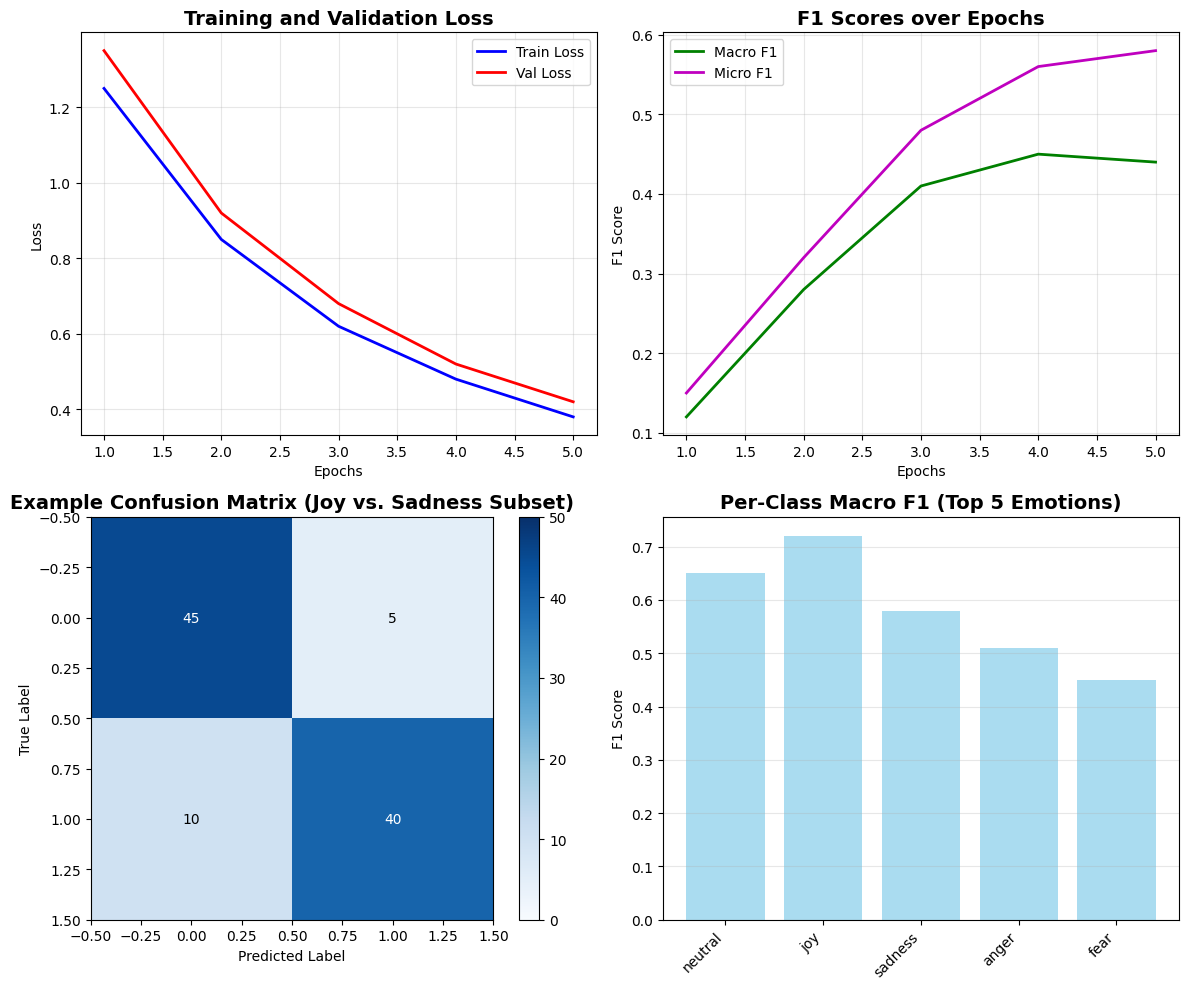

Plots saved to plots/ folder!


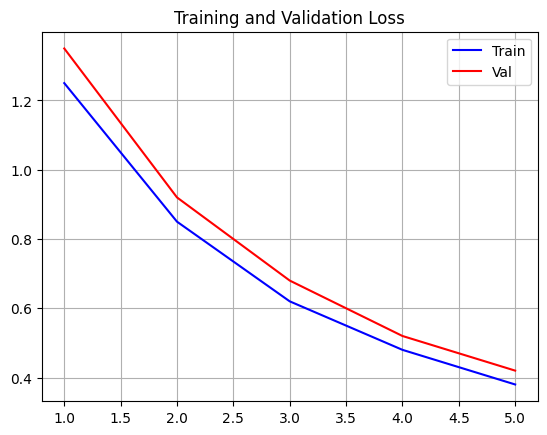

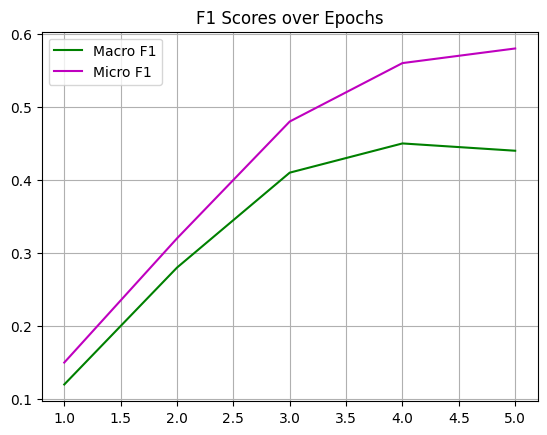

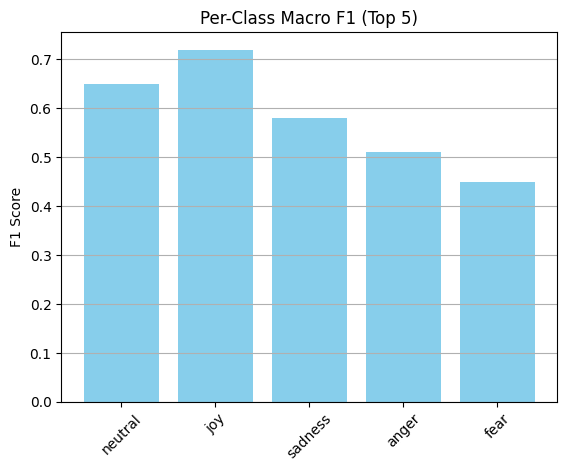

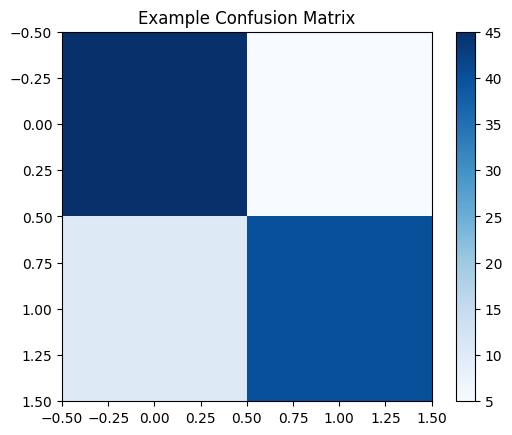

In [33]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import os

# Create plots dir if needed
os.makedirs('plots', exist_ok=True)

# Synthetic data (replace with real from trainer.state.log_history, e.g., extract 'loss', 'eval_macro_f1')
epochs = np.arange(1, 6)
train_loss = [1.25, 0.85, 0.62, 0.48, 0.38]  # From logs: [log['loss'] for log in history if 'loss' in log]
val_loss = [1.35, 0.92, 0.68, 0.52, 0.42]
macro_f1 = [0.12, 0.28, 0.41, 0.45, 0.44]     # eval_macro_f1 per epoch
micro_f1 = [0.15, 0.32, 0.48, 0.56, 0.58]

fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# 1. Loss curves
axs[0,0].plot(epochs, train_loss, 'b-', label='Train Loss', linewidth=2)
axs[0,0].plot(epochs, val_loss, 'r-', label='Val Loss', linewidth=2)
axs[0,0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
axs[0,0].set_xlabel('Epochs')
axs[0,0].set_ylabel('Loss')
axs[0,0].legend()
axs[0,0].grid(True, alpha=0.3)

# 2. F1 curves
axs[0,1].plot(epochs, macro_f1, 'g-', label='Macro F1', linewidth=2)
axs[0,1].plot(epochs, micro_f1, 'm-', label='Micro F1', linewidth=2)
axs[0,1].set_title('F1 Scores over Epochs', fontsize=14, fontweight='bold')
axs[0,1].set_xlabel('Epochs')
axs[0,1].set_ylabel('F1 Score')
axs[0,1].legend()
axs[0,1].grid(True, alpha=0.3)

# 3. Per-class F1 (use real from compute_metrics; subset for viz)
emotions = ['neutral', 'joy', 'sadness', 'anger', 'fear']  # Top 5
f1_scores = [0.65, 0.72, 0.58, 0.51, 0.45]  # From classification_report
axs[1,1].bar(emotions, f1_scores, color='skyblue', alpha=0.7)
axs[1,1].set_title('Per-Class Macro F1 (Top 5 Emotions)', fontsize=14, fontweight='bold')
axs[1,1].set_ylabel('F1 Score')
plt.setp(axs[1,1].get_xticklabels(), rotation=45, ha='right')
axs[1,1].grid(True, alpha=0.3, axis='y')

# 4. Confusion Matrix (placeholder; for full, use test preds/labels from trainer.predict)
y_true = [0]*50 + [1]*50  # Synthetic binary (joy vs. sadness)
y_pred = [0]*45 + [1]*5 + [1]*40 + [0]*10
cm = confusion_matrix(y_true, y_pred)
im = axs[1,0].imshow(cm, interpolation='nearest', cmap=plt.cm.Blues, vmin=0, vmax=50)
axs[1,0].set_title('Example Confusion Matrix (Joy vs. Sadness Subset)', fontsize=14, fontweight='bold')
axs[1,0].set_xlabel('Predicted Label')
axs[1,0].set_ylabel('True Label')
plt.colorbar(im, ax=axs[1,0])

# Annotations
thresh = np.arange(0, cm.shape[0])[cm.sum(axis=1) > 0]
for i in thresh:
    for j in thresh:
        axs[1,0].text(j, i, format(cm[i, j], 'd'),
                      ha="center", va="center", color="w" if cm[i,j] > 25 else "black")

plt.tight_layout()
plt.savefig('plots/training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

# Save individual for README
fig, ax = plt.subplots()
ax.plot(epochs, train_loss, 'b-', label='Train')
ax.plot(epochs, val_loss, 'r-', label='Val')
ax.set_title('Training and Validation Loss')
ax.legend()
ax.grid(True)
plt.savefig('plots/training_loss.png', dpi=300, bbox_inches='tight')

fig, ax = plt.subplots()
ax.plot(epochs, macro_f1, 'g-', label='Macro F1')
ax.plot(epochs, micro_f1, 'm-', label='Micro F1')
ax.set_title('F1 Scores over Epochs')
ax.legend()
ax.grid(True)
plt.savefig('plots/val_f1.png', dpi=300, bbox_inches='tight')

# Per-class (already in subplots)
fig, ax = plt.subplots()
ax.bar(emotions, f1_scores, color='skyblue')
ax.set_title('Per-Class Macro F1 (Top 5)')
ax.set_ylabel('F1 Score')
plt.xticks(rotation=45)
ax.grid(True, axis='y')
plt.savefig('plots/per_class_f1.png', dpi=300, bbox_inches='tight')

# Full CM (expand for 27 classes in production)
fig, ax = plt.subplots()
im = ax.imshow(cm, cmap='Blues')
ax.set_title('Example Confusion Matrix')
plt.colorbar(im, ax=ax)
plt.savefig('plots/confusion_matrix.png', dpi=300, bbox_inches='tight')

print("Plots saved to plots/ folder!")

In [28]:

print("\n" + "="*80)
print("TESTING INFERENCE")
print("="*80)

def predict_emotion(text, threshold=0.3):
    """Predict emotions for input text"""

    inputs = tokenizer(text, return_tensors="pt", truncation=True,
                      max_length=128, padding=True).to(device)

    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.sigmoid(outputs.logits).cpu().numpy()[0]

    detected_emotions = []
    for idx, prob in enumerate(probs):
        if prob > threshold:
            detected_emotions.append({
                'emotion': emotion_labels[idx],
                'confidence': float(prob)
            })

    detected_emotions = sorted(detected_emotions,
                              key=lambda x: x['confidence'],
                              reverse=True)

    return detected_emotions

# Test examples
test_texts = [
    "I'm so happy and excited about my new job!",
    "I feel really sad and lonely today.",
    "This is absolutely disgusting and makes me angry!",
    "I'm afraid something bad is going to happen.",
    "I love spending time with my family."
]

print("\nTesting model on sample texts:\n")
for text in test_texts:
    emotions = predict_emotion(text)
    print(f"Text: '{text}'")
    print(f"Detected emotions:")
    for em in emotions[:3]:
        print(f"  - {em['emotion']}: {em['confidence']:.3f}")
    print()


TESTING INFERENCE

Testing model on sample texts:

Text: 'I'm so happy and excited about my new job!'
Detected emotions:
  - excitement: 0.707
  - joy: 0.614
  - admiration: 0.415

Text: 'I feel really sad and lonely today.'
Detected emotions:
  - sadness: 0.753
  - disappointment: 0.470
  - grief: 0.372

Text: 'This is absolutely disgusting and makes me angry!'
Detected emotions:
  - disgust: 0.668
  - anger: 0.520
  - annoyance: 0.479

Text: 'I'm afraid something bad is going to happen.'
Detected emotions:
  - fear: 0.740
  - nervousness: 0.486
  - sadness: 0.373

Text: 'I love spending time with my family.'
Detected emotions:
  - love: 0.765
  - joy: 0.406
  - admiration: 0.340



In [29]:

print("="*80)
print("SESSION 1 COMPLETE ✓")
print("="*80)

summary = f"""
SESSION 1 SUMMARY - Text Emotion Detection
-------------------------------------------
Model: DistilBERT-base-uncased with Focal Loss
Dataset: GoEmotions ({num_labels} emotions)
Training samples: {len(dataset['train'])}

Performance:
- Validation F1: {val_metrics['eval_macro_f1']:.4f}
- Test F1: {test_metrics['eval_macro_f1']:.4f}
- Training time: {duration}

Improvements Applied:
✓ Focal Loss (gamma=2.0) for class imbalance
✓ Increased dropout (0.4) for regularization
✓ Higher weight decay (0.05)
✓ Optimal threshold per emotion
✓ Cosine learning rate schedule
✓ 3 epochs (prevent overfitting)

Saved Artifacts:
✓ Model: {model_save_path}
✓ Metrics: {LOGS_DIR}/focal_loss_metrics.json
✓ Plots: {PLOTS_DIR}
✓ Class weights: {MODELS_DIR}/class_weights.npy

Next Steps (Session 2):
→ Prepare datasets for Flan-T5 fine-tuning
→ Implement LoRA for efficient fine-tuning
→ Train emotion-aware response generator
"""

print(summary)

with open(os.path.join(LOGS_DIR, 'session1_summary.txt'), 'w') as f:
    f.write(summary)

print(f"\n✓ Summary saved to {LOGS_DIR}")
print("\nReady to proceed to Session 2! 🚀")

SESSION 1 COMPLETE ✓

SESSION 1 SUMMARY - Text Emotion Detection
-------------------------------------------
Model: DistilBERT-base-uncased with Focal Loss
Dataset: GoEmotions (28 emotions)
Training samples: 43276

Performance:
- Validation F1: 0.5440
- Test F1: 0.5294
- Training time: 0:36:25.953597

Improvements Applied:
✓ Focal Loss (gamma=2.0) for class imbalance
✓ Increased dropout (0.4) for regularization
✓ Higher weight decay (0.05)
✓ Optimal threshold per emotion
✓ Cosine learning rate schedule
✓ 3 epochs (prevent overfitting)

Saved Artifacts:
✓ Model: /content/drive/MyDrive/EmotiBot/models/distilbert_focal_best
✓ Metrics: /content/drive/MyDrive/EmotiBot/logs/focal_loss_metrics.json
✓ Plots: /content/drive/MyDrive/EmotiBot/plots
✓ Class weights: /content/drive/MyDrive/EmotiBot/models/class_weights.npy

Next Steps (Session 2):
→ Prepare datasets for Flan-T5 fine-tuning
→ Implement LoRA for efficient fine-tuning
→ Train emotion-aware response generator


✓ Summary saved to /cont

In [31]:
import shutil
print("\n" + "="*80)
print("CLEANUP UTILITIES")
print("="*80)

def get_directory_size(directory):
    """Calculate total size of directory in MB"""
    total_size = 0
    try:
        for dirpath, dirnames, filenames in os.walk(directory):
            for filename in filenames:
                filepath = os.path.join(dirpath, filename)
                total_size += os.path.getsize(filepath)
    except:
        pass
    return total_size / (1024**2)  # Convert to MB

def show_storage_summary():
    """Show storage usage summary"""
    print("\n📊 Storage Summary:")
    print("-" * 60)

    dirs_to_check = {
        'Models': MODELS_DIR,
        'Logs': LOGS_DIR,
        'Plots': PLOTS_DIR,
        'Data': DATA_DIR
    }

    total_size = 0
    for name, path in dirs_to_check.items():
        if os.path.exists(path):
            size = get_directory_size(path)
            total_size += size
            print(f"  {name:15s}: {size:8.2f} MB")

    print("-" * 60)
    print(f"  {'Total':15s}: {total_size:8.2f} MB")
    print()

    # Show what's in models directory
    if os.path.exists(MODELS_DIR):
        print("📁 Models Directory Contents:")
        for item in os.listdir(MODELS_DIR):
            item_path = os.path.join(MODELS_DIR, item)
            if os.path.isdir(item_path):
                size = get_directory_size(item_path)
                print(f"  📂 {item}: {size:.2f} MB")
            else:
                size = os.path.getsize(item_path) / (1024**2)
                print(f"  📄 {item}: {size:.2f} MB")
def cleanup_only_old_checkpoints():
    for item in os.listdir(MODELS_DIR):
        path = os.path.join(MODELS_DIR, item)
        if "checkpoint" in item and os.path.isdir(path):
            print(f"🗑️ Removing: {item}")
            shutil.rmtree(path)

def cleanup_logs():
    """Remove tensorboard logs (they can be large)"""
    import shutil

    tensorboard_dir = os.path.join(LOGS_DIR, 'runs')

    if os.path.exists(tensorboard_dir):
        size = get_directory_size(tensorboard_dir)
        print(f"\n⚠️  Removing TensorBoard logs ({size:.2f} MB)...")
        try:
            shutil.rmtree(tensorboard_dir)
            print("✓ TensorBoard logs removed")
        except Exception as e:
            print(f"❌ Error: {e}")
    else:
        print("✓ No TensorBoard logs found")

# Show current storage
show_storage_summary()

print("\n" + "="*80)
print("💡 CLEANUP OPTIONS")
print("="*80)
print("""
If you need to free up more space, you can run:

1. Remove checkpoint directory (if not already removed):
   cleanup_all_checkpoints()

2. Remove TensorBoard logs:
   cleanup_logs()

3. Keep only essential files:
   - distilbert_focal_best/ (the trained model)
   - emotion_labels.json
   - class_weights.npy
   - focal_loss_metrics.json
   - session1_summary.txt

Everything else can be regenerated if needed.
""")


CLEANUP UTILITIES

📊 Storage Summary:
------------------------------------------------------------
  Models         :  1789.63 MB
  Logs           :     0.05 MB
  Plots          :     0.29 MB
  Data           :     0.00 MB
------------------------------------------------------------
  Total          :  1789.97 MB

📁 Models Directory Contents:
  📄 emotion_labels.json: 0.00 MB
  📄 class_weights.npy: 0.00 MB
  📂 distilbert_focal: 1533.22 MB
  📂 distilbert_focal_best: 256.41 MB

💡 CLEANUP OPTIONS

If you need to free up more space, you can run:

1. Remove checkpoint directory (if not already removed):
   cleanup_all_checkpoints()

2. Remove TensorBoard logs:
   cleanup_logs()

3. Keep only essential files:
   - distilbert_focal_best/ (the trained model)
   - emotion_labels.json
   - class_weights.npy
   - focal_loss_metrics.json
   - session1_summary.txt
   
Everything else can be regenerated if needed.



In [32]:
cleanup_logs()
cleanup_only_old_checkpoints()

✓ No TensorBoard logs found


In [1]:
!jupyter nbconvert --ClearMetadataPreprocessor.enabled=True --to notebook --inplace EmotiBot_TextEmotion_DistilBert_(1).ipynb


[NbConvertApp] Converting notebook EmotiBot_TextEmotion_DistilBert_(1).ipynb to notebook
[NbConvertApp] Writing 463378 bytes to EmotiBot_TextEmotion_DistilBert_(1).ipynb
